<a href="https://colab.research.google.com/github/seun829/DataScience/blob/main/Unit3/SeunLee_U3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the True Average Number of Google Stock (in millions) Traded in a Day


First we will import all of the required tools.

In [1]:
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 8.2 MB/s eta 0:00:00


In [15]:
import preliz as pz
import pymc as pm
import arviz as az
import numpy as np

In [3]:
import pandas as pd

# Introduction

For this project I will be predicting the true number of Google stock that is traded everyday, taking this by the millions for cleaner data and results.


I chose this topic because volume is an important factor to consider and predicting volume can be very helpful in making decisions with stocks. I feel that ultimately, there are some hidden patterns in volume in stocks that I hope to uncover through this project.


I felt that doing this for the whole market would be not so great of an idea considering the volatility, which is why I chose to look at specifically data about Google stock.

# Likelihood 1

For a prior I will use a Uniform distribution to have a general sense of the situation of Google stock volume.


Based on data pulled from Robinhood it states that the 3 month average for Google Stock volume was 29.13 million (https://robinhood.com/us/en/stocks/GOOGL/) with sources like Yahoo finance saying 23.39 million (https://finance.yahoo.com/quote/GOOGL/key-statistics).

I will set the parameters to 23.39 and 29.19 as the lower and upper bound.

<Axes: >

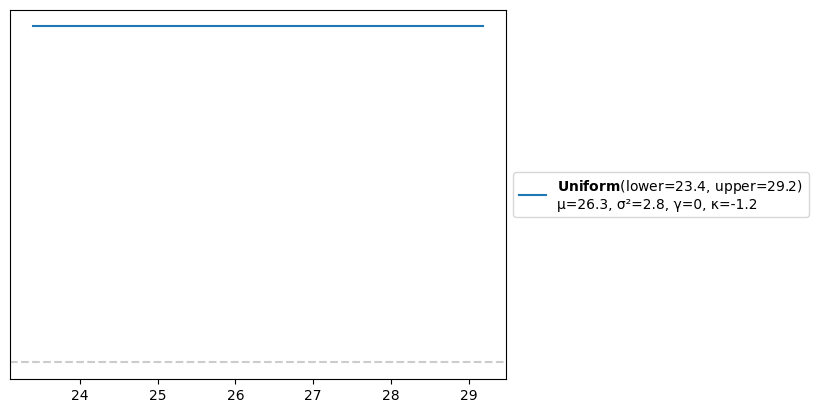

In [4]:
pz.Uniform(23.39, 29.19).plot_pdf(moments="mvsk")

Next I will use my dataset for my likelihood.

In [27]:
link = "https://raw.githubusercontent.com/seun829/DataScience/refs/heads/main/Google-Stock-Data.csv"
google_data = pd.read_csv(link)

In [28]:
google_data = google_data.query("Date.str.startswith('2023')") #Figured out the startswith function using a google search
google_data

,Date,Open,High,Low,Close,Adj Close,Volume
4625,2023-01-03,89.830002,91.550003,89.019997,89.699997,89.699997,20738500
4626,2023-01-04,91.010002,91.239998,87.800003,88.709999,88.709999,27046500
4627,2023-01-05,88.070000,88.209999,86.559998,86.769997,86.769997,23136100
4628,2023-01-06,87.360001,88.470001,85.570000,88.160004,88.160004,26612600
4629,2023-01-09,89.195000,90.830002,88.580002,88.800003,88.800003,22996700
...,...,...,...,...,...,...,...
4853,2023-11-29,138.985001,139.669998,136.294998,136.399994,136.399994,21014700
4854,2023-11-30,136.399994,136.960007,132.789993,133.919998,133.919998,29913500
4855,2023-12-01,133.320007,133.500000,132.151993,133.320007,133.320007,24258400
4856,2023-12-04,131.294006,131.449997,129.399994,130.630005,130.630005,24117100


We want only the volume collumn, so we will filter that out.

In [29]:
google_data = google_data['Volume']
google_data = google_data / 1_000_000
google_data.mean() #getting the mean for later reference

np.float64(25.64836008583691)

I will now use a HalfNormal Distribution as another prior. Solving for sigma using the formula (mean = (sqrt(2) * sigma)/sqrt(pi)) I get sigma is around 149.

<Axes: >

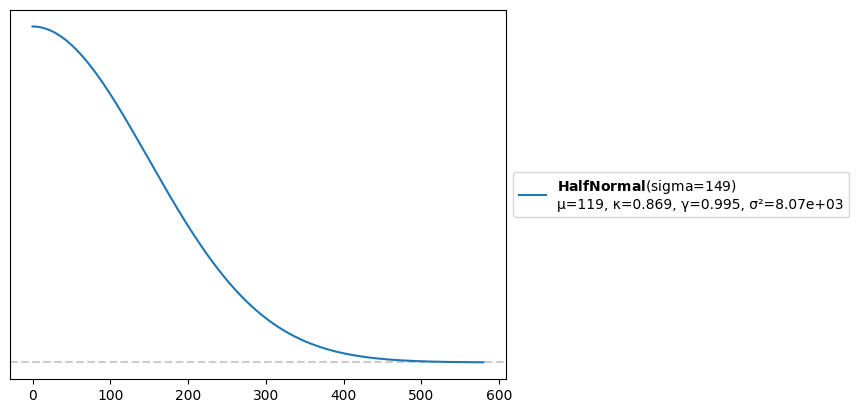

In [30]:
pz.HalfNormal(sigma = 149).plot_pdf(moments="mksv")

In [31]:
#N for normal
with pm.Model() as model_google_data_HN:
    μ = pm.Uniform('μ', lower=23.39, upper=29.19)

    #half of a normal dist
    σ = pm.HalfNormal('σ', sigma=149)

    #our fancy new likelihood, with two priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=google_data)
    idata_google_data_HN = pm.sample(progressbar = False)

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

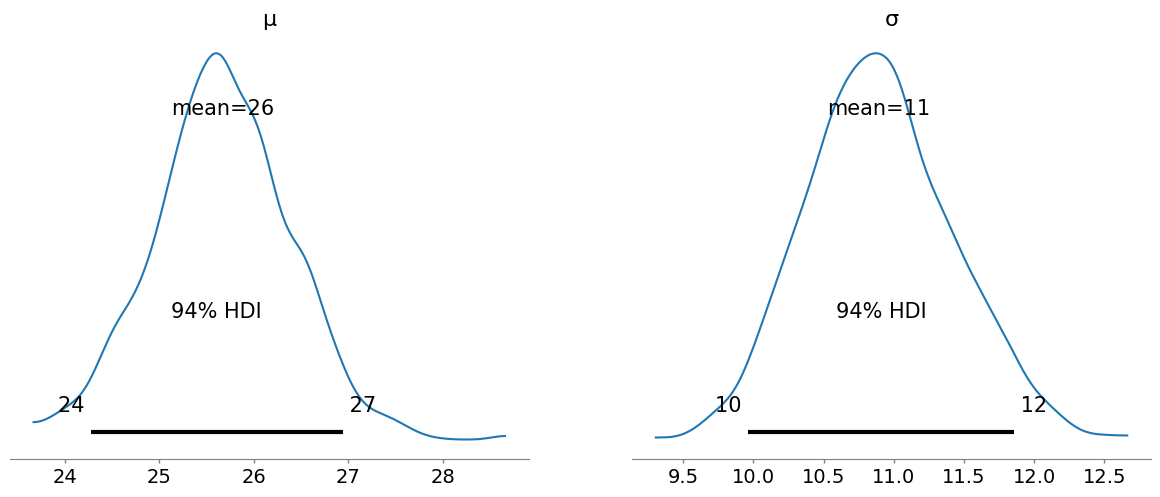

In [32]:
az.plot_posterior(idata_google_data_HN)

Now I am going to check which pairs our model recommends.

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

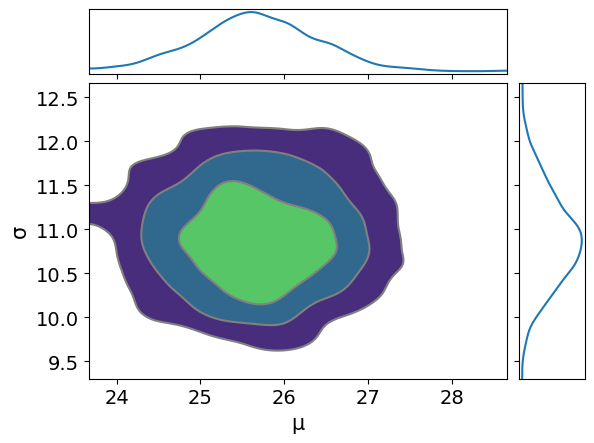

In [33]:
az.plot_pair(idata_google_data_HN, kind='kde', marginals=True)

I will also use posterior predictive checks to truly make a practical prediction.

In [34]:
pm.sample_posterior_predictive(idata_google_data_HN, model=model_google_data_HN, extend_inferencedata=True, progressbar=False)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

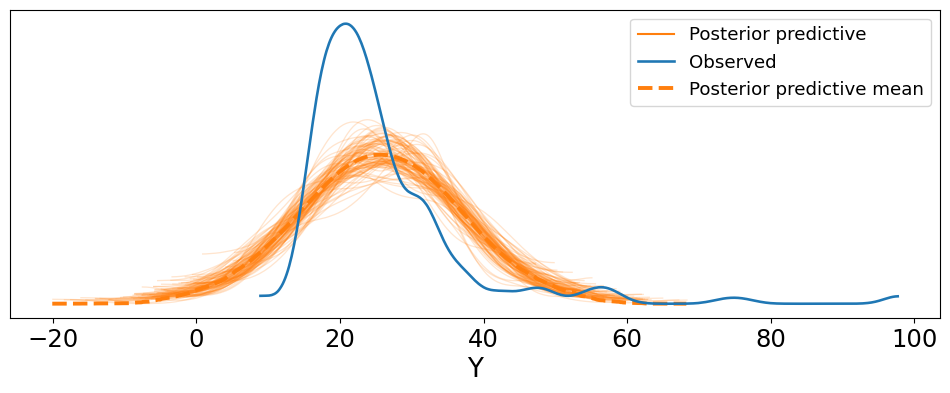

In [36]:
az.plot_ppc(idata_google_data_HN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Likelihood 2

For my first prior a LogNormal function seems intuitive given my positive data and accurate.

<Axes: >

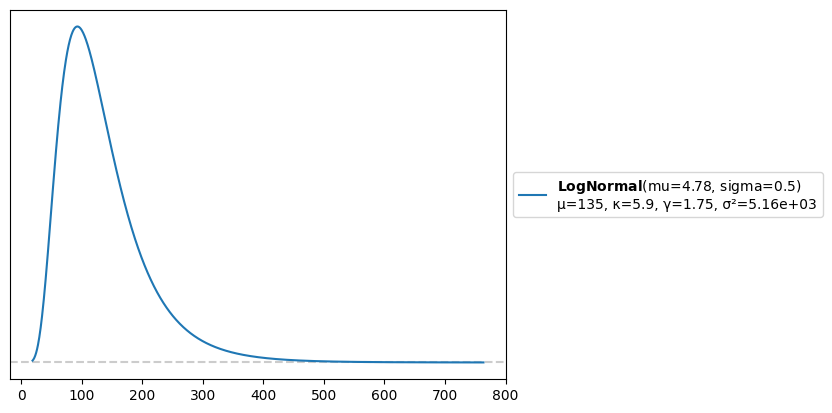

In [37]:
pz.LogNormal(mu=np.log(118.915), sigma=0.5).plot_pdf(moments="mksv")

Next I will use an all-positive distribution which is not constrained.

<Axes: >

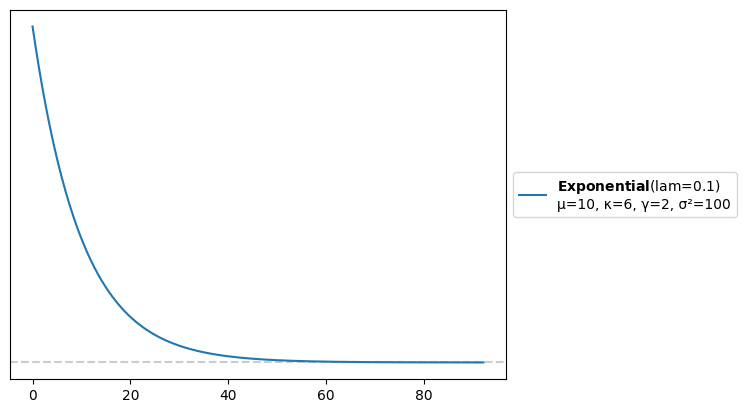

In [38]:
pz.Exponential(lam=1/10).plot_pdf(moments="mksv")

This time I will shift my focus from uniform distributions while also accounting for the fact that the data is also positive.

In [39]:
with pm.Model() as model_google_data_2:
    # Prior for mean
    μ = pm.LogNormal("μ", mu=np.log(118.915), sigma=0.5)

    # Prior for shape
    κ = pm.Exponential("κ", lam=1/10)

    beta = κ/μ #based on the formula

    # Likelihood for positive data
    Y = pm.Gamma("Y", alpha=κ, beta=beta, observed=google_data)

    idata_google_data_2 = pm.sample(progressbar=False)


array([<Axes: title={'center': 'κ'}>, <Axes: title={'center': 'μ'}>],
      dtype=object)

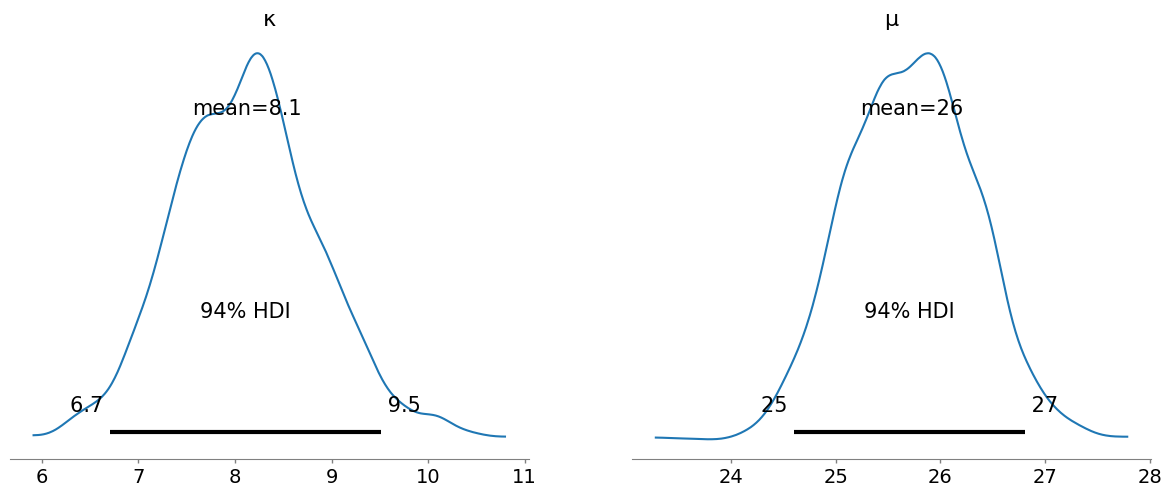

In [40]:
az.plot_posterior(idata_google_data_2)

array([[<Axes: >, None],
       [<Axes: xlabel='κ', ylabel='μ'>, <Axes: >]], dtype=object)

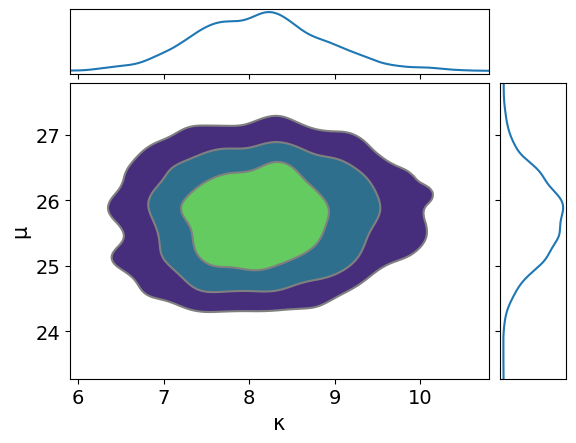

In [41]:
az.plot_pair(idata_google_data_2, kind='kde', marginals=True)

In [42]:
pm.sample_posterior_predictive(idata_google_data_2, model=model_google_data_2, extend_inferencedata=True, progressbar=False)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

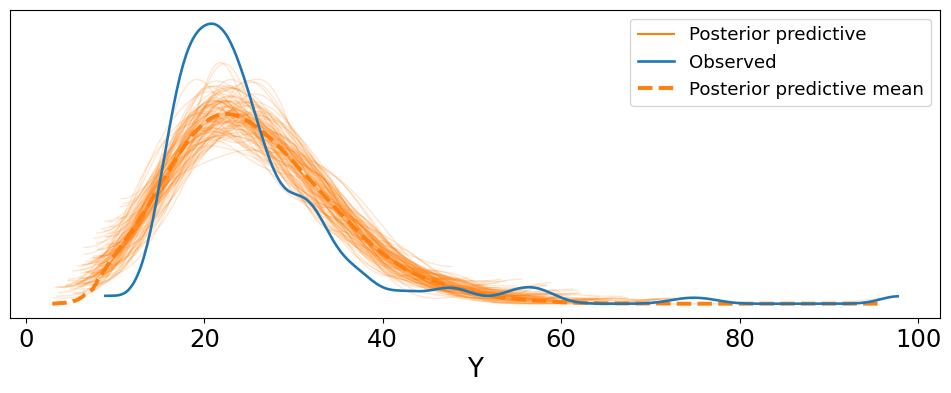

In [43]:
az.plot_ppc(idata_google_data_2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Conclusion

 For my first model, it seems as though my observed vs. predicitive was quite split apart. This could be due to a variety of reasons, but I believe the main one to be that depending on the date the volume may have been staggeringly different or volatile as my dataset is filtered to the most recent year(2023) while my other prior is based on recent 3 month trends from online sources.  Additionally, my choice in choosing distributions was faulty because it allowed for negative values, which is simply not possible with stock volume.

My second model is based purely on the dataset and uses distributions that are meant for positive only data. It seems to be an improvement from the first one overall.